1 and 2:

Statistical Summary:


,3,4,5,6,7,8,9,10,11,12,13,14,Label
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854,0.148312,2.000000
std,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149,0.273005,0.817348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000,0.000000,2.000000
75%,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000,0.150000,3.000000
max,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000,1.000000,3.000000


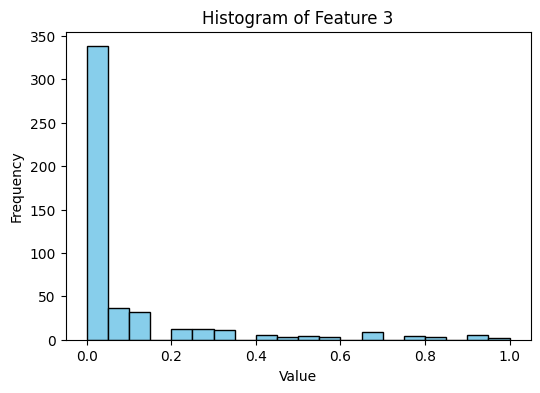

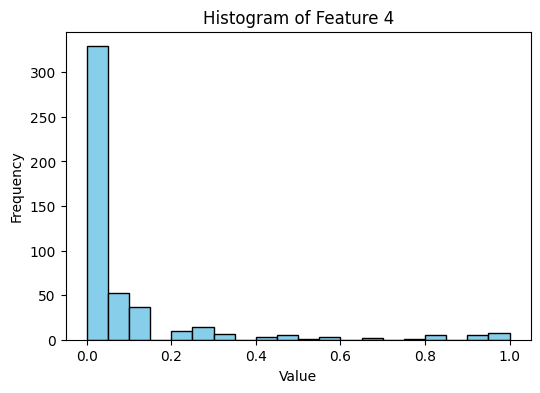

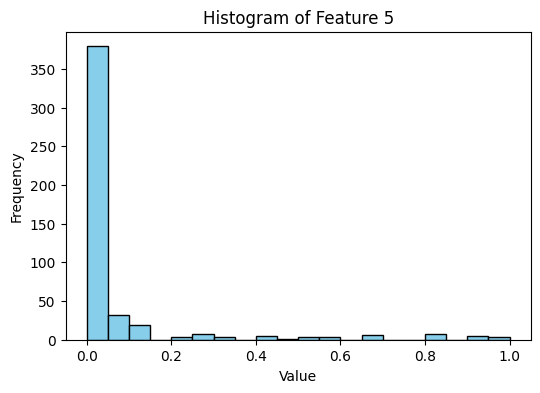

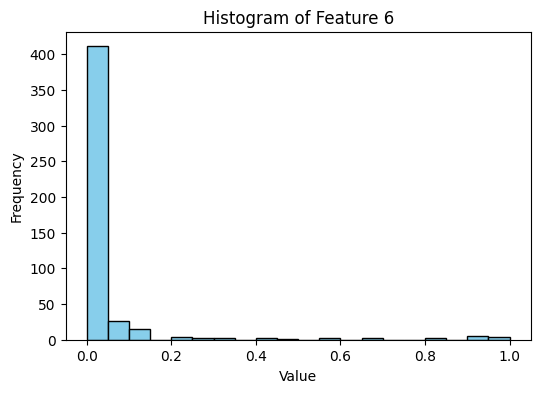

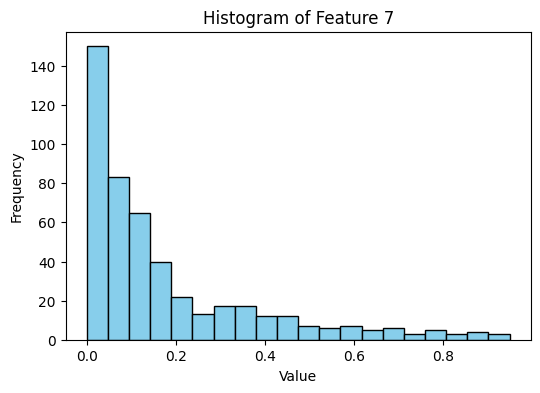

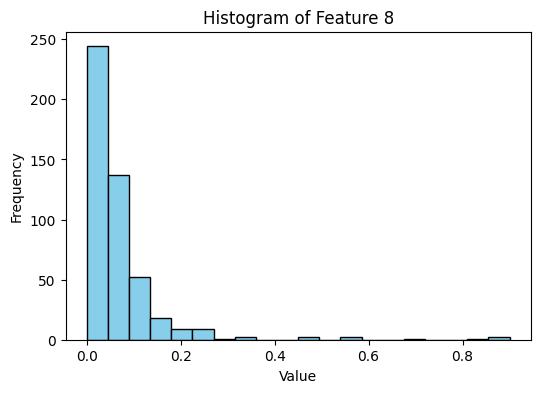

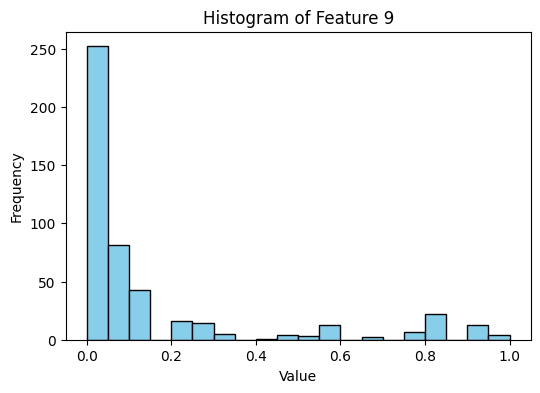

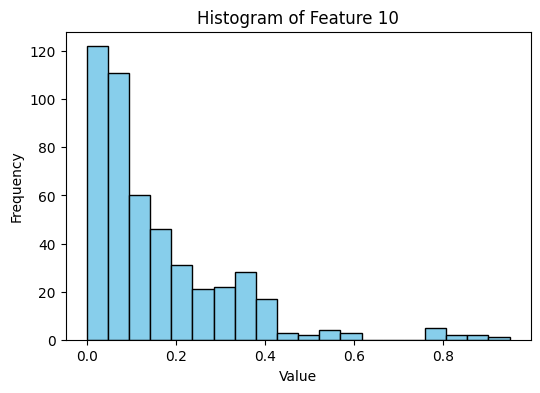

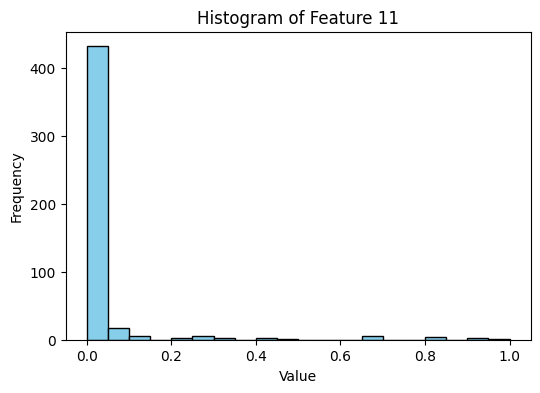

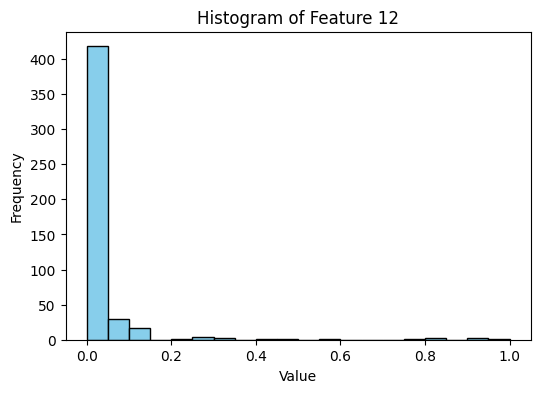

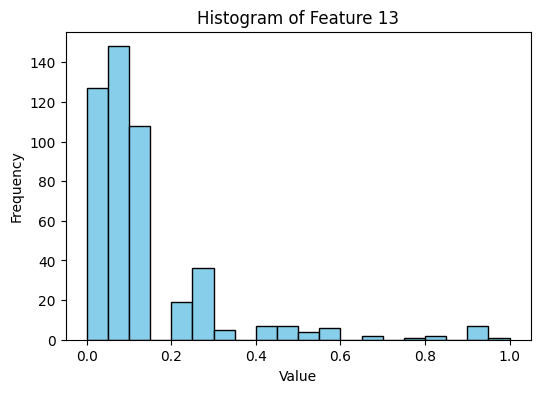

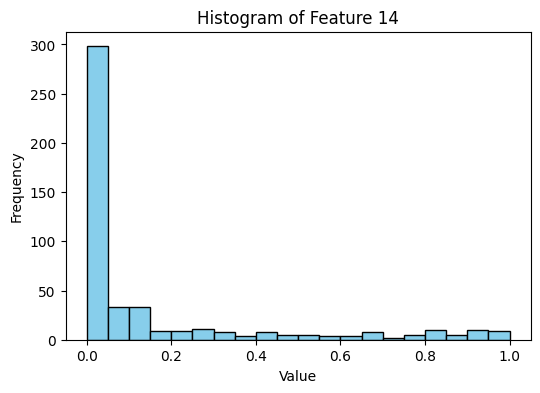

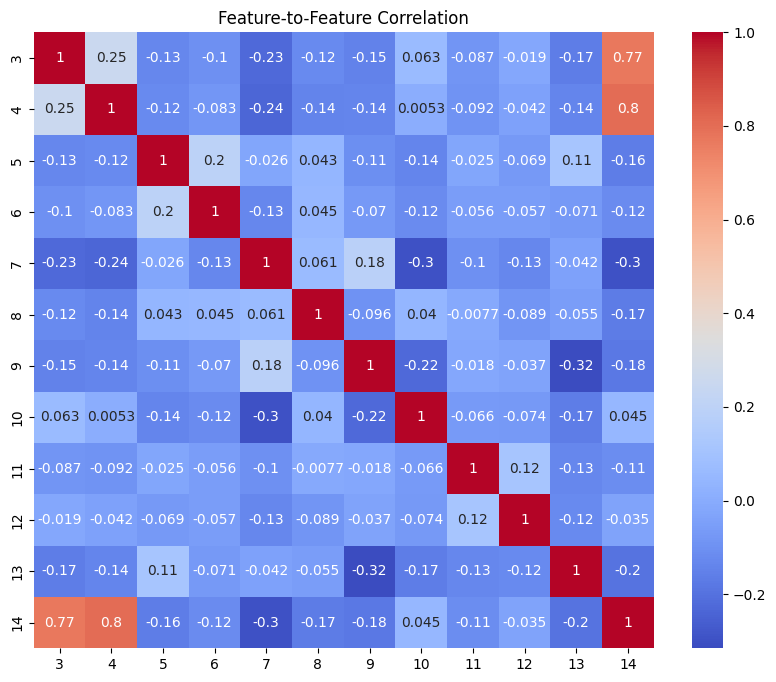

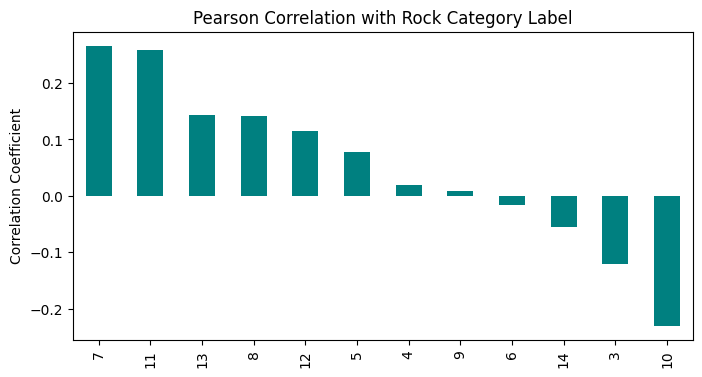

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Load Data
labels_df = pd.read_excel("aggregateRockData.xlsx", engine="openpyxl")
features_df = pd.read_csv("feature_presence540.txt", sep=r"\s+", header=None)

labels = labels_df.iloc[:480, 1].astype(int)  # Column 2 = rock category
features = features_df.iloc[:480, 3:15].astype(float)  # Columns 4–14 = features
tokens = features_df.iloc[:480, 2].astype(int)  # Column 3 = token number

# Combine into one DataFrame
data = features.copy()
data['Label'] = labels

# Statistical Summary
print("Statistical Summary:")
display(data.describe())

# Histograms
for col in features.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of Feature {col}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Pearson Correlation Between Features
plt.figure(figsize=(10, 8))
sns.heatmap(data[features.columns].corr(), annot=True, cmap='coolwarm')
plt.title("Feature-to-Feature Correlation")
plt.show()

# Correlation with Label
label_corr = {}
for col in features.columns:
    corr, _ = pearsonr(data[col], data['Label'])
    label_corr[col] = corr


# Visualize correlation with label
plt.figure(figsize=(8, 4))
pd.Series(label_corr).sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Pearson Correlation with Rock Category Label")
plt.ylabel("Correlation Coefficient")
plt.show()



Features are all highly skewed, but log transformation will not help much since these values are all bewteen 0 and 1

Many attributes have 25th, 50th, and even 75th percentiles at 0, indicating that a large portion of the data is zero. This suggests sparse features, which may not be informative

- Can do feature selection because of this to remove non-informative features

Some attributes have max values significantly higher than the mean and 75th percentile, indicating potential outliers

- Possible help to clip certain outliers and values like how attribute 6 has a mean of 0.042292	 and a max of 1

high PCC:
3 and 14
4 and 14

this shows that these attributes have a very good positive linear relationship showing their correlation together

Most other PCC are close to 0 showing they have no correlation with other attributes at all

There is also not a very distinct attribute that correlates with the label they are all about -0.2-0.25 which shows a very minimal correlation. Not enough for it to be significant


3.

In [107]:

# Training: tokens 7–16
train_data = data[(tokens >= 7) & (tokens <= 16)]

# Validation: tokens 4–6
val_data = data[(tokens >= 4) & (tokens <= 6)]

# Testing: tokens 1–3
test_data = data[(tokens >= 1) & (tokens <= 3)]


In [108]:
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Separate features and labels for each split
X_train, y_train = train_data.drop('Label', axis=1), train_data['Label']
X_val, y_val = val_data.drop('Label', axis=1), val_data['Label']
X_test, y_test = test_data.drop('Label', axis=1), test_data['Label']

# Scale features for Logistic Regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Helper function for evaluation

def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    # Generate classification reports
    train_report = classification_report(y_tr, model.predict(X_tr), output_dict=True)
    val_report = classification_report(y_val, model.predict(X_val), output_dict=True)
    test_report = classification_report(y_te, model.predict(X_te), output_dict=True)

    # Extract overall metrics
    metrics = pd.DataFrame({
        'Train': [train_report['accuracy'], train_report['macro avg']['precision'], train_report['macro avg']['recall'], train_report['macro avg']['f1-score']],
        'Validation': [val_report['accuracy'], val_report['macro avg']['precision'], val_report['macro avg']['recall'], val_report['macro avg']['f1-score']],
        'Test': [test_report['accuracy'], test_report['macro avg']['precision'], test_report['macro avg']['recall'], test_report['macro avg']['f1-score']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])

    print("\nPerformance Summary:")
    display(metrics)

    # Plot metrics
    metrics.T.plot(kind='bar', figsize=(8, 6))
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.show()


4.

A.

Best Logistic Regression Params: {'C': 100, 'max_iter': 25, 'solver': 'lbfgs'}

Performance Summary:


,Train,Validation,Test
Accuracy,0.730000,0.611111,0.655556
Precision,0.732905,0.611939,0.665791
Recall,0.730000,0.611111,0.655556
F1-score,0.729008,0.611411,0.652617


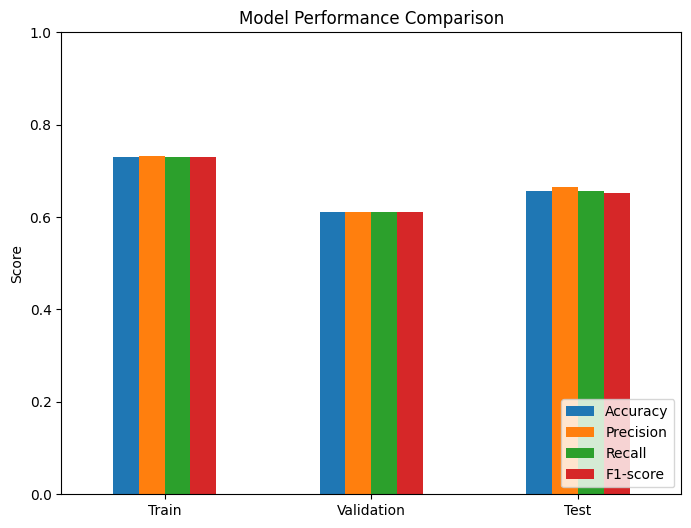

In [109]:
# Logistic Regression (Softmax)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
    'max_iter': [10, 25, 50, 100, 200, 500, 1000]
}

lr = LogisticRegression(multi_class='multinomial')
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

evaluate_model(best_lr, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Hyper Parameters:
---------------------
C: Controls trade-off of regularization

- Smaller C = stronger regularization -> less overfitting but possible underfitting

- Larger C = weak regularization -> better fit training data but risk of overfit


Solver: Determines the optimization algorithm

- liblinear: best for snall datasets and binary classification

- lbfgs: Supports L2 regularization, good for medium/large datasets

- newton-cg:best for large datasets and multiclass classification, supports l2 regularization

- saga: Supports l1,l2, and elastic-net regularization



Max Number of Iterations: how ling solver runs

- if too low, the model may not converge and underfit

- if too high the model could run for too long




B.

Best SVM Params: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Performance Summary:


,Train,Validation,Test
Accuracy,0.720000,0.677778,0.700000
Precision,0.734046,0.689600,0.733187
Recall,0.720000,0.677778,0.700000
F1-score,0.716509,0.675606,0.690421


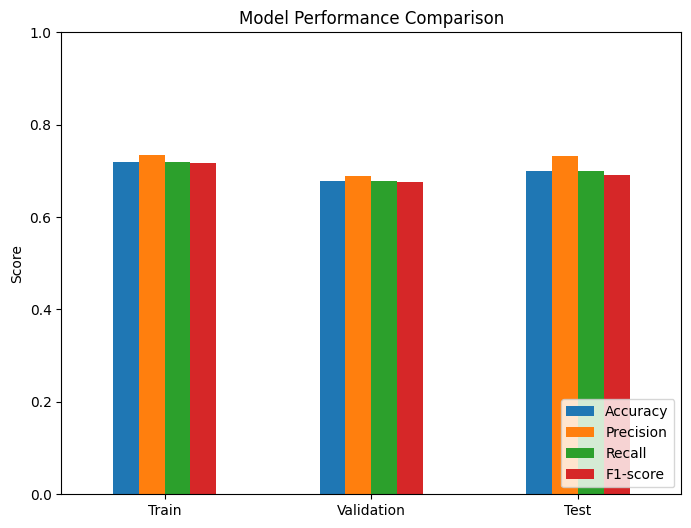

In [110]:
# SVM with Grid Search
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)

print("Best SVM Params:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

evaluate_model(best_svm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)


Hyper Parameters
---------------------

C: regularization

- low C = more tolerance for missclassification/wider margin may underfit

- high C = smaller margin so less tolerance and may overfit

Kernel: transforms data into higher dimensions where it becomes linearly separable, allowing a standard linear classifier to find a decision boundary


Degree: Cotnrols the complexitiy of the polynomial kernel

- hgiher degree = more complex decision boundaries can possibly overfit data

Gamma: How far the influence of a training example reaches

- Low gamma = smoother decision boundary

- High gamma = more complex nboundary where it runs the reisk of overfitting

C.

Best Random Forest Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}

Performance Summary:


,Train,Validation,Test
Accuracy,0.803333,0.544444,0.677778
Precision,0.810562,0.546885,0.679819
Recall,0.803333,0.544444,0.677778
F1-score,0.803212,0.542033,0.671943


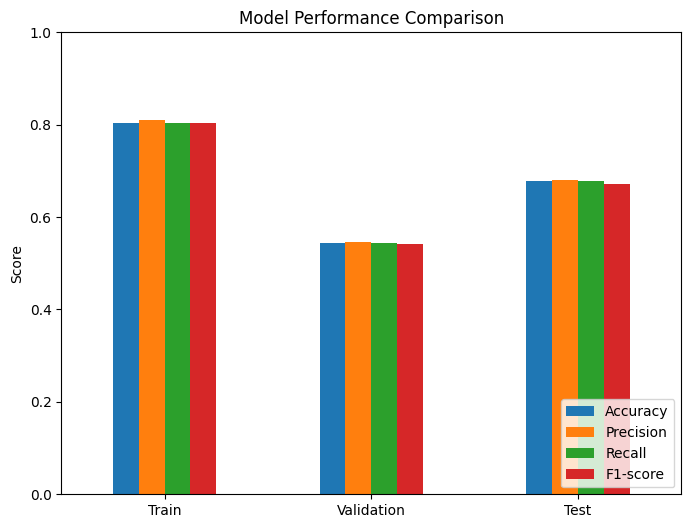

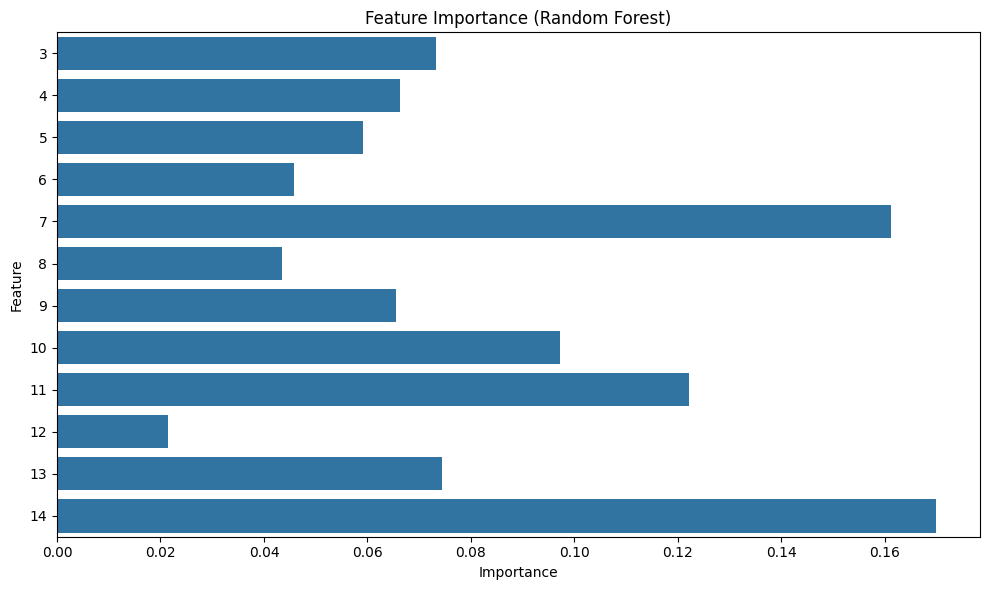

In [111]:
# Random Forest with Grid Search
param_grid_rf = {
    'n_estimators': [10 ,25, 50, 100, 200],
    'max_depth': [None, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

evaluate_model(best_rf, X_train, y_train, X_val, y_val, X_test, y_test)

# Feature importance
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx], orient='h')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Hyper Parameters
-----------------

Number of trees (n_estimators):

- The more trees, possible better performance

- helps reduce the variance

Max depth: limit of tree depth

- shallow: possible risk of underfitting

- Deep: risk of overfitting

Min samples to split: minimum samples required to split a node

- higher values is a more conservative split which can reduce overfitting

Min samples at leaf: minimum samples required at a leaf node

- this helps prevent very specific rules that can cause overfitting



5. Ensembles

Hard Voting Ensemble

Ensemble Performance on Validation Set:

Performance Summary:


,Train,Validation,Test
Accuracy,0.750000,0.644444,0.677778
Precision,0.757931,0.654521,0.704580
Recall,0.750000,0.644444,0.677778
F1-score,0.749144,0.644258,0.675378


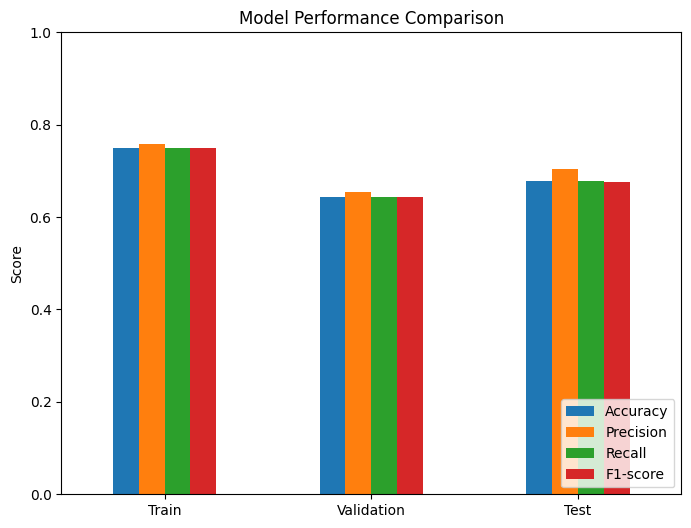

In [112]:
from sklearn.ensemble import VotingClassifier

# Create ensemble using the best models found from GridSearch
ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', best_svm),
        ('rf', best_rf)
    ],
    voting='hard'
)

# Train ensemble on training set
ensemble.fit(X_train_scaled, y_train)

# Evaluate on validation set first
print("Ensemble Performance on Validation Set:")
evaluate_model(ensemble, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Soft Voting Ensemble

Soft Voting Ensemble Performance:

Performance Summary:


,Train,Validation,Test
Accuracy,0.780000,0.633333,0.700000
Precision,0.782423,0.654444,0.714286
Recall,0.780000,0.633333,0.700000
F1-score,0.779290,0.632742,0.697451


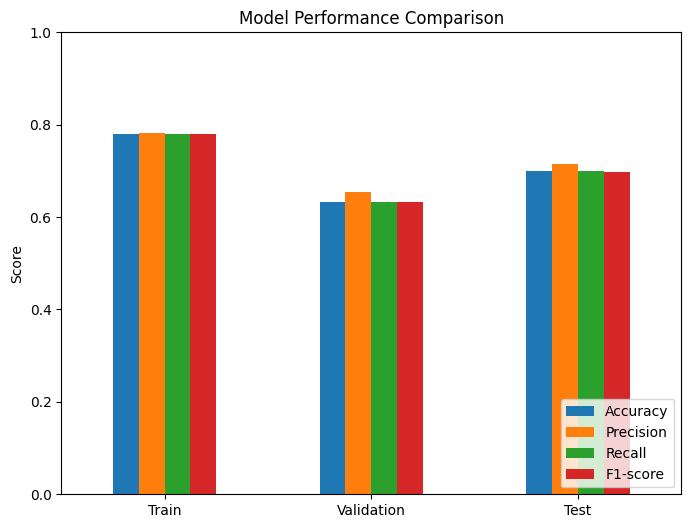

In [113]:
# Enable probability for SVM
svm_soft = SVC(C=best_svm.C, kernel=best_svm.kernel, degree=best_svm.degree,
               gamma=best_svm.gamma, probability=True)

ensemble_soft = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', svm_soft),
        ('rf', best_rf)
    ],
    voting='soft',
    weights=[1, 1, 2]
)

ensemble_soft.fit(X_train_scaled, y_train)

print("Soft Voting Ensemble Performance:")
evaluate_model(ensemble_soft, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Stacking Ensemble (Best)

Stacking Ensemble Performance:

Performance Summary:


,Train,Validation,Test
Accuracy,0.766667,0.611111,0.711111
Precision,0.773200,0.619829,0.719501
Recall,0.766667,0.611111,0.711111
F1-score,0.767451,0.609097,0.709624


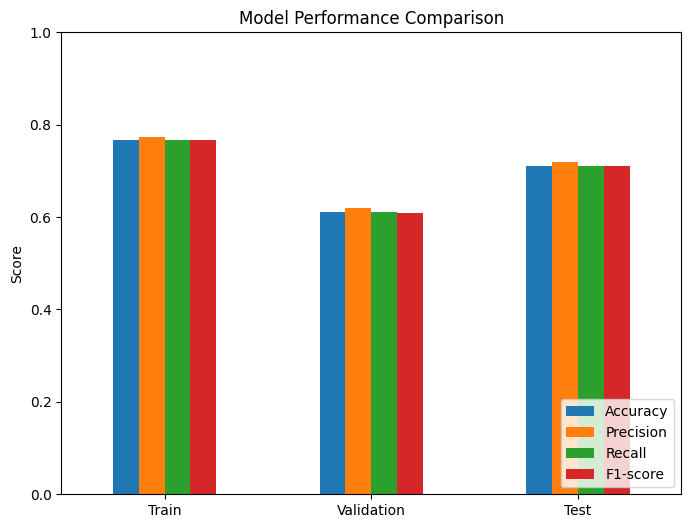

In [114]:
from sklearn.ensemble import StackingClassifier

# Meta-classifier: Logistic Regression
stacking = StackingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', best_svm),
        ('rf', best_rf)
    ],
    final_estimator=LogisticRegression(max_iter=500)
)

stacking.fit(X_train_scaled, y_train)

print("Stacking Ensemble Performance:")
evaluate_model(stacking, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Stacking ensemble is best ensemble used even when trying different weights for soft voting classifier

6.

In [115]:
# Load trialData.csv
trial_data = pd.read_csv("trialData.csv")

# Filter for rocks 1–480 and Block number 4
filtered_data = trial_data[
    (trial_data['rocknumber'].between(1, 480)) &
    (trial_data['block'] == 4)
]

# Compute average human accuracy (cat_correct = 1 if correct, 0 if not)
human_accuracy = filtered_data['cat_correct'].mean()

print(f"Average Human Accuracy (Block 4, rocks 1–480): {human_accuracy:.4f}")


Average Human Accuracy (Block 4, rocks 1–480): 0.5984


Accuracy
---------------
Human: 0.5984

Softmax regression: 0.655

SVM: 0.700

Random Forest: 0.677

Ensemble(Stacking): 0.711

All the models are more accurate than the human identification

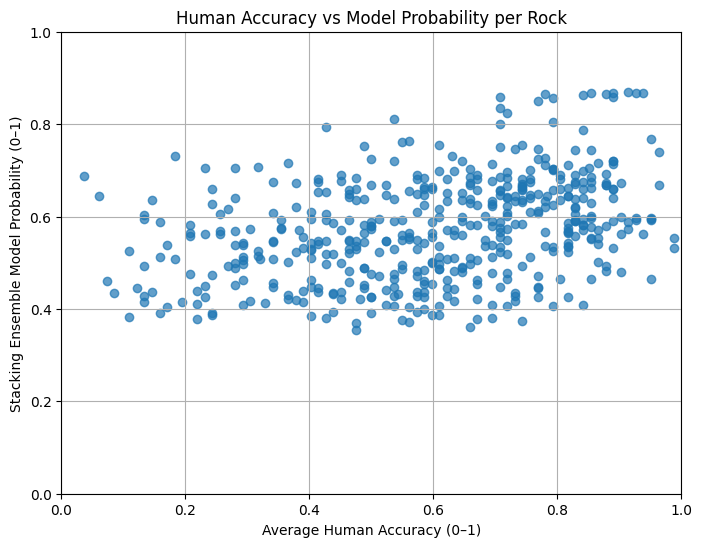

In [116]:


# Compute average human accuracy per rock
human_accuracy_per_rock = (
    filtered_data.groupby('rocknumber')['cat_correct']
    .mean()
    .reindex(range(1, 481))
)

X_all_scaled = scaler.transform(features)

# Get model probabilities for each rock
model_probs = stacking.predict_proba(X_all_scaled).max(axis=1)

# Combine into one DataFrame
comparison_df = pd.DataFrame({
    'Human_Accuracy': human_accuracy_per_rock.values,
    'Model_Probability': model_probs
}, index=range(1, 481))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Human_Accuracy'], comparison_df['Model_Probability'], alpha=0.7)
plt.title("Human Accuracy vs Model Probability per Rock")
plt.xlabel("Average Human Accuracy (0–1)")
plt.ylabel("Stacking Ensemble Model Probability (0–1)")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [121]:
# Get predicted probabilities for each model
features_scaled = scaler.transform(features)
lr_probs = best_lr.predict_proba(features_scaled)
svm_probs = best_svm.predict_proba(features_scaled)
rf_probs = best_rf.predict_proba(features)
ensemble_probs = stacking.predict_proba(features_scaled)

# Extract probability for the true class for each rock
lr_correct_probs = [lr_probs[i][labels[i]-1] for i in range(len(labels))]
svm_correct_probs = [svm_probs[i][labels[i]-1] for i in range(len(labels))]
rf_correct_probs = [rf_probs[i][labels[i]-1] for i in range(len(labels))]
ensemble_correct_probs = [ensemble_probs[i][labels[i]-1] for i in range(len(labels))]

# Compute correlation for each model
results = {}
for name, probs in {
    'Logistic Regression': lr_correct_probs,
    'SVM': svm_correct_probs,
    'Random Forest': rf_correct_probs,
    'Ensemble': ensemble_correct_probs
}.items():
    corr, pval = pearsonr(human_accuracy_per_rock, probs)
    results[name] = (corr, pval)

# Display results
for model, (corr, pval) in results.items():
    print(f"{model}: Correlation = {corr:.4f}, p-value = {pval:.4e}")

Logistic Regression: Correlation = 0.5400, p-value = 1.0896e-37
SVM: Correlation = 0.5414, p-value = 6.7138e-38
Random Forest: Correlation = 0.5173, p-value = 3.3650e-34
Ensemble: Correlation = 0.5775, p-value = 4.9408e-44


All the correlatons fall from about 0.51-0.58

This is a positive correlation that shows that moderately, not highly, the rocks that humans find easier to identify are also the ones the models are more confidently identifying

The p- values are very small, this indicates that this similarity is very unlikely due to random chance, but instead they are statistically significant